In [10]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from pathlib import Path
import ruamel.yaml as yaml
from tqdm.notebook import tqdm
import scipy.stats as stats
%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.1.0


In [2]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

class dist_env():

    def __init__(self, decision_threshold=0.9, n_timesteps=1000):
        self.keep_record = True
        self.n_timesteps = n_timesteps
        self.n_states = 4
        self.stay_prob = 1. - 1./20.
        self.M_weighting_off_diagonal = 0.1
        self.decision_threshold = decision_threshold
        self.wait_reward = -0.2
        self.wrong_reward = -1.
        self.right_reward = +1.
        self.observation_sigma = 0.5
        self.reset()


    def reset(self, ):
        self.reset_M()
        self.reset_M_random()
        self.done = False
        self.t = 0
        r = self.wait_reward
        o = 0
        self.prev_state = np.random.randint(0, self.n_states)
        
        self._s_hist = np.array([self.prev_state])
        self._r_hist = np.array([])
        self._o_hist = np.array([])
        
        return o, r, self.done, self.t        


    def reset_M(self, ):
        self.trans_prob = (1.-self.stay_prob) / (self.n_states-1)
        self.M = np.eye(self.n_states) * self.stay_prob
        self.M[np.logical_not(np.eye(self.M.shape[0], dtype=bool))] = self.trans_prob


    def reset_M_random(self, ):
        M = np.identity(self.n_states)
        M += self.M_weighting_off_diagonal*np.random.lognormal(size=M.shape)
        M /=np.sum(M, axis=1, keepdims=True)
        self.M = M


    def step(self, action_prob):
        assert not self.done
        prev_state = self.prev_state
        r = self.comp_reward(action_prob, prev_state)
        s = self.comp_transition(action_prob, prev_state)
        o = self.compute_observation(s)
        
        self.t += 1
        if self.t >= self.n_timesteps:
            self.done = True
        self.prev_state = s
        
        if self.keep_record:
            self._r_hist = np.append(self._r_hist, r)
            self._s_hist = np.append(self._s_hist, s)
            self._o_hist = np.append(self._o_hist, o)
            
        return o, r, self.done, self.t


    def comp_reward(self, action_prob, s):
        s_guess = np.argmax(action_prob)
        if np.max(action_prob) >= self.decision_threshold:
            if s_guess == s:
                r = self.right_reward
            else:
                r = self.wrong_reward
        else:
            r = self.wait_reward
        
        return r


    def comp_transition(self, action_prob, prev_state):
        s = np.random.choice(self.n_states, p=self.M[prev_state,:])
        if np.max(action_prob) >= self.decision_threshold:
            while s == prev_state:
                s = np.random.choice(self.n_states, p=self.M[prev_state,:])
        return s


    def compute_observation(self, s):
        o = stats.norm.rvs(loc=s, scale=self.observation_sigma)
        return o

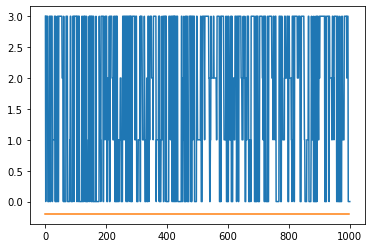

In [68]:
env = dist_env()


for i in range(1000):
    env.step(np.array([0.5, 0.01, 0.01, 0.01]))


plt.figure()
plt.plot(env._s_hist)
plt.plot(env._r_hist)

In [81]:
(np.diff(env._s_hist) == 0)[:15], env._s_hist[:15]

(array([False, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True]),
 array([3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3]))

In [83]:
np.unique(env._s_hist[:-1][(np.diff(env._s_hist) == 0)], return_counts=True)

(array([0, 1, 2, 3]), array([217,  87,  73, 305]))

In [66]:
env.reset()

(0, -0.2, False, 0)

In [67]:
env.step(np.array([0.99, 0.01, 0.01, 0.01]))

(2.912811854297331, -1.0, False, 1)

In [58]:
class Model(tf.keras.Model):
    def __init__(self, num_actions, batch_size=1, n_timesteps=None, n_features=7, name='meta_policy'):
        super().__init__(name)
#         Having a stateful LSTM means that you will need to reset the hidden state 
#         in between batches yourself if you do want independent batches. 
#         The default initial hidden state in Tensorflow is all zeros.
        self.lstm = kl.LSTM(
            48, name='hidden', 
            stateful=True, 
            time_major=True, # ['time', 'batch', 'features']
            return_sequences=True, 
            recurrent_initializer='zeros'
        )
        self.lstm.build((n_timesteps, batch_size, n_features)) # set batch size, must be done with stateful lstm
        self.policy = kl.Dense(
            num_actions, name='policy',
            activation='softmax'
        )
        self.value = kl.Dense(
            1, name='value'
        )

    def call(self, inputs, **kwargs):
        output = self.lstm(inputs)
        value = self.value(output)
        policy = self.policy(output)
        return tf.squeeze(policy, 1), tf.squeeze(value, (1, 2))

In [59]:
# Verify everything works by sampling two actions.
state_observation, reward, done, timestep = env.reset()
model = Model(env.n_states, n_features=7)

action = np.array([0.5, 0.01, 0.01, 0.01])
single_input = np.concatenate([
    [[state_observation]],
    [[reward]],
    [action],
    [[timestep]]], 1)
single_input = tf.cast(single_input, dtype=tf.float32)
single_input = tf.expand_dims(single_input, [1])
# print(single_input)
action, value = model(single_input)
print(action, value)
# print(action.shape, value.shape)

tf.Tensor([[0.24663241 0.2513803  0.24803975 0.25394753]], shape=(1, 4), dtype=float32) tf.Tensor([-0.00325102], shape=(1,), dtype=float32)


In [60]:
# Verify everything works by sampling two actions with state reset.
state_observation, reward, done, timestep = env.reset()
model = Model(env.n_states, n_features=7)

action = np.array([0.5, 0.01, 0.01, 0.01])
for _ in range(2):
    single_input = np.concatenate([
        [[state_observation]],
        [[reward]],
        [action],
        [[timestep]]], 1)
    single_input = tf.cast(single_input, dtype=tf.float32)
    single_input = tf.expand_dims(single_input, [1])

    action, value = model(single_input)
    action = np.squeeze(action)
    print(action, value)
    state_observation, reward, done, timestep = env.step(action)
    

[0.24818532 0.2505948  0.2484034  0.25281647] tf.Tensor([-0.0404446], shape=(1,), dtype=float32)
[0.23897804 0.257765   0.25061363 0.25264335] tf.Tensor([-0.0359579], shape=(1,), dtype=float32)


In [110]:
class Agent:
    def __init__(self, model, learning_rate=1e-3, gamma=0.8, value_coefficient=0.2, entropy_coefficient=.002, name='a2c_agent_alex', data_path=None):
        # `gamma` is the discount factor; coefficients are used for the loss terms.
        self.gamma = gamma
        self.value_coefficient = value_coefficient
        self.learning_rate = learning_rate
        self.entropy_coefficient = entropy_coefficient
        self.env =  dist_env()
        self.name = name
        self.model = model(env.n_states, batch_size=1, name=self.name)
        # Define separate losses for policy logits and value estimate.
        self.data_path = data_path or Path().cwd() / self.name
        self.parameters = {
            'learning_rate': learning_rate,
            'value_coefficient': value_coefficient,
            'entropy_coefficient': entropy_coefficient,
            'gamma': gamma 
        }
        self._compile()
    
    def save_agent(self):
        self.data_path.mkdir(parents=True, exist_ok=True)
        logging.info(f"Saving parameters, training_history and weights to {self.data_path}.")
        with open(str(self.data_path / self.name) + '.yaml', 'w') as f:
            yaml.dump(self.parameters, f)
        np.save(str(self.data_path / self.name) + '.npy', self.training_history)
        self.model.save_weights(str(self.data_path / self.name))
        
    def load_agent(self):
        logging.warning("Updating parameters, training_history, weights and recompiling model.")
        with open(str(self.data_path / self.name) + '.yaml', 'r') as f:
            self.parameters = yaml.load(f, Loader=yaml.Loader)
        self.training_history = np.load(str(self.data_path / self.name) + '.npy')
        self.model.load_weights(str(self.data_path / self.name))
        self.__dict__.update(self.parameters)
        self._compile()
        
    def _compile(self):
        self.model.compile(
            optimizer=ko.Adam(lr=self.learning_rate), 
            loss=[self._policy_loss, self._value_loss])
    
    def _predict(self, action, state_observation, reward, timestep):
        action = np.squeeze(action)
        single_input = np.concatenate([
            [[state_observation]],
            [[reward]],
            [action],
            [[timestep]]], 1)
        single_input = tf.cast(single_input, dtype=tf.float32)
        single_input = tf.expand_dims(single_input, [1])
        new_action, value = self.model(single_input)
        return new_action, value, single_input

    def train(self, episodes=250):
        # Training loop: collect samples, send to optimizer, repeat episodes times.
        self.training_history = []
        for episode in tqdm(range(episodes)):
            actions, observations, rewards, values, inputs = self.run_episode()
            self.training_history.append(np.sum(rewards))

            logging.info(f"Episode: {len(self.training_history) - 1:3d}, Reward: {int(self.training_history[-1]):3d}")
            
            # `next_value` is the bootstrap value estimate of the future state (critic).
            _, next_value, _ = self._predict(actions[-1], observations[-1], rewards[-1], inputs[-1,0,3] + 1)

            self.model.reset_states()
            
            returns, advantages = self._returns_advantages(rewards, values, next_value)
            # A trick to input actions and advantages through same API.
            actions_advantages = np.concatenate([actions, advantages[:, None]], axis=1)
            
            losses = self.model.train_on_batch(inputs, [actions_advantages, returns])
            
            logging.debug(f"[{episode + 1:d}/{episodes:d}] Losses: {losses}")
        return self.training_history

    def run_episode(self):
        state_observation, reward, done, timestep = self.env.reset()

        action = np.array([0.0, 0.0, 0.0, 0.0])
        # Storage helpers for a single batch of data.
        actions = np.empty((self.env.n_timesteps, len(action)), dtype=np.int32)
        rewards, values, observations = np.empty((3, self.env.n_timesteps))
        inputs = np.empty((self.env.n_timesteps, 1, 7))
        
        self.model.reset_states()
        step = 0
        while not done:
            # action and reward at t - 1 and timestep at t
            action, value, inputs[step] = self._predict(action, state_observation, reward, timestep + 1)
            state_observation, reward, done, timestep = self.env.step(action)
            # rewards, values and actions at t
            observations[step] = state_observation
            rewards[step] = reward
            actions[step] = action
            values[step] = value
            step += 1
        return actions, observations, rewards, values, inputs
    
    def _returns_advantages(self, rewards, values, next_value):
        # `next_value` is the bootstrap value estimate of the future state (critic).
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # Returns are calculated as discounted sum of future rewards.
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        returns = returns[:-1]
        # Advantages are equal to returns - baseline (value estimates in our case).
        advantages = returns - values
        return returns, advantages

    def _value_loss(self, returns, value):
        # Value loss is typically MSE between value estimates and returns.
        loss = self.value_coefficient * kls.mean_squared_error(returns, value)
#         tf.keras.backend.print_tensor(loss)
        return loss

    def _policy_loss(self, actions_advantages, logits):
        # A trick to input actions and advantages through the same API.
        actions, advantages = actions_advantages[:,:4], actions_advantages[:,4]
        # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
        # `from_logits` argument ensures transformation into normalized probabilities.
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # Policy loss is defined by policy gradients, weighted by advantages.
        # Note: we only calculate the loss on the actions we've actually taken.
        actions = tf.reduce_max(actions, axis=1)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # Entropy loss can be calculated as cross-entropy over itself.
        probs = tf.nn.softmax(logits)
        entropy_loss = tf.reduce_sum(kls.categorical_crossentropy(probs, probs))
        # We want to minimize policy and maximize entropy losses.
        # Here signs are flipped because the optimizer minimizes.
#         tf.keras.backend.print_tensor(policy_loss)
#         tf.keras.backend.print_tensor(entropy_loss)
        loss = policy_loss - self.entropy_coefficient * entropy_loss
        return loss

In [111]:
# logging.getLogger().setLevel(logging.INFO)
# logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.WARNING)


agent = Agent(Model)

_, rewards, _, _, _ = agent.run_episode()
print(sum(rewards))

1301.3189206633238


# train

In [ ]:
training_history = agent.train(10000)

print("Finished training! Testing...")
print("Total Episode Reward: %d out of 100" % agent.run_episode()[1].sum())

# or load weights

In [ ]:
agent.save_agent()

In [15]:
agent.load_agent()

In [117]:
agent.run_episode()[1].sum()

1483.7592512178014

Text(0, 0.5, 'Total Reward')

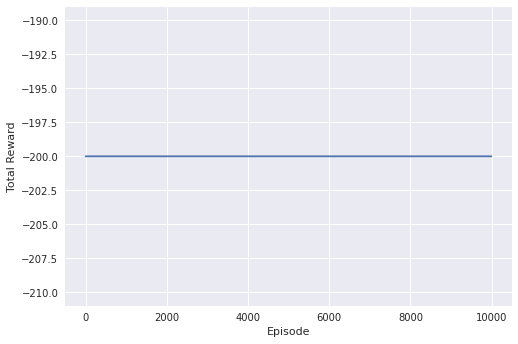

In [115]:
plt.style.use('seaborn')
plt.plot(np.arange(0, len(agent.training_history), 5), agent.training_history[::5])
# plt.plot(np.arange(len(training_history)), training_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# analyze model

In [16]:
class Benchmark:
    def __init__(self, agent, env_name=None, n_episodes=300):
        self.agent = agent
        self.env_name = env_name or agent.env_name
        self.env = dependent_bandit(self.env_name)
        self.n_episodes = n_episodes
    
    def evaluate(self):
        rewards = np.empty((self.n_episodes, env.n_timesteps))
        actions = np.empty((self.n_episodes, env.n_timesteps))
        values = np.empty((self.n_episodes, env.n_timesteps))
        bandits = np.empty((self.n_episodes, 2))
        for episode in tqdm(range(self.n_episodes)):
            actions[episode], rewards[episode], values[episode], _ = agent.run_episode(self.env)
            bandits[episode] = self.env.bandit
        self.episodes = {
            'rewards': rewards,
            'actions': actions,
            'values': values,
            'bandits': bandits
        }
            
    def hist(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        plt.hist(self.episodes['rewards'].sum(1) / (self.env.bandit.max() * 100))
        
    def plot_cumulative_regret(self):
        if not hasattr(self, 'episodes'):
            self.evaluate()
        if self.env.difficulty == 'uniform':
            raise NotImplementedError
        regret = self.env.bandit.max() - self.episodes['rewards'].mean(0)
        plt.plot(np.cumsum(regret))
        
    def plot_rewards(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()

        im = plt.imshow(self.episodes['rewards'], cmap='binary', origin='lower', interpolation='nearest')
        
#         patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
#         plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)
    
    def plot_actions(self):
        import matplotlib.patches as mpatches
        if not hasattr(self, 'episodes'):
            self.evaluate()
        actions_optimal = np.empty_like(self.episodes['actions'])
        _itr = zip(self.episodes['actions'], np.argmax(self.episodes['bandits'], 1))
        
        for i, (actions_episode, optimal_choice) in enumerate(_itr):
            actions_optimal[i] = actions_episode == optimal_choice

        im = plt.imshow(actions_optimal, cmap='Greens_r', origin='lower', interpolation='nearest')
        
        patches = [mpatches.Patch(color=im.cmap(im.norm(0)), label="Sub-optimal choice")]
        plt.legend(handles=patches, )
        
        plt.gca().set_aspect('auto')
        plt.grid(False)

In [23]:
b = Benchmark(agent, 'easy')
b.evaluate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


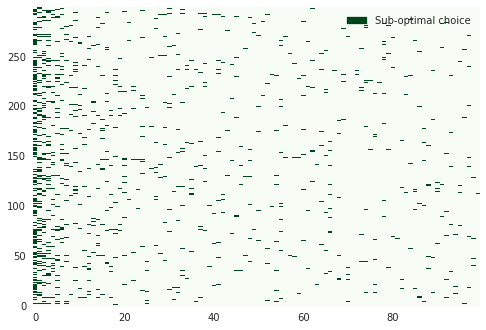

In [24]:
b.plot_actions()
# plt.xlim(0,1)

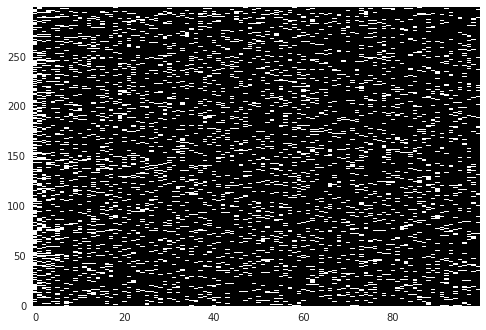

In [25]:
b.plot_rewards()

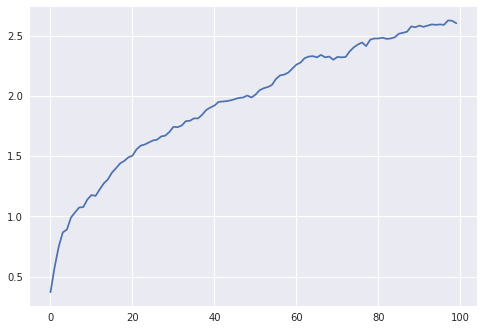

In [26]:
b.plot_cumulative_regret()

In [ ]:
class ManualBenchmark:
    def __init__(self, agent):
        self.agent = agent
    
    def play(self):
        agent.model.reset_states()
        action, reward, timestep, done = 0, 0, 1, 0
        actions, rewards, values = [] * 3
        while reward >= 0:
            # action and reward at t - 1 and timestep at t
            action, value, _ = agent._predict(action, reward, timestep)
            reward = input(f"LSTM chose {action}, give me a reward 0 or 1 (-1 ends the game)")
            reward = int(reward)
            # rewards, values and actions at t
            rewards.append(reward)
            actions.append(action)
            values.append(value)
            timestep += 1
        return actions, rewards, values

In [ ]:
mb = ManualBenchmark(agent)

In [ ]:
mb.play()